In [66]:
# !pip install pydot
# !apt install graphviz

In [67]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [68]:
# #To read traing data of google share price
# df=pd.read_csv('/content/drive/MyDrive/BTC_Prediction_Training/data/btc.csv')
# #training_set user defined dataframe
# df.head()

In [69]:
# df.drop('Unnamed: 0', axis=1, inplace=True)

In [70]:
# df.head()

In [71]:
# df1 = df.iloc[:, 4:5].values

# df1

In [72]:
from sklearn.model_selection import train_test_split

def pre_processing(df, test_size=0.2):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])

    # df1 = df.iloc[:, 1:2].values  # Only 'Open' price
    df1 = df[['Open']].values

    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    df1 = mms.fit_transform(df1)

    X_all = df1[:-1]
    Y_all = df1[1:]

    # Reshape inputs for LSTM
    X_all = np.reshape(X_all, (X_all.shape[0], 1, 1))

    # Time-aware train-test split (no shuffling!)
    split_index = int(len(X_all) * (1 - test_size))
    X_train, X_test = X_all[:split_index], X_all[split_index:]
    Y_train, Y_test = Y_all[:split_index], Y_all[split_index:]

    return X_train, Y_train, X_test, Y_test, mms


In [73]:
#Part-2 : -

def model_training(X_train,Y_train):

  #Building the RNN with LSTM
  #Recurrent neural network
  #LSTM means long short term memory
  from tensorflow.keras.models import Sequential #initialise neural network
  from tensorflow.keras.layers import Dense #to add input layer,output layer,
  #and hidden layer
  from tensorflow.keras.layers import LSTM  #to use built the model
  #LSTM : to manage internal memory , to store previous o/p
  #long short term memory


  #create objecgt of Sequential class
  model=Sequential()

  #To add layers in model
  #This layer are input layer and LSTM layer
  model.add(LSTM(units=4,activation='sigmoid',input_shape=(None,1)))
  #None means to take no. of rows and 1 means 1 column

  #To add output layer
  model.add(Dense(units=1,activation='linear'))

  #compile the model
  model.compile(optimizer='adam',loss='mean_squared_error')

  model.summary()

  from tensorflow.keras.utils import plot_model
  plot_model(model, show_shapes=True, show_layer_names=True)


  #early stopping
  from tensorflow.keras.callbacks import EarlyStopping
  #procedure for callback(EarlyStopping)
  callback = EarlyStopping(
      monitor="val_loss",
      min_delta=0.00001,
      patience=20,
      verbose=1,
      mode="auto",
      baseline=None,
      restore_best_weights=True
  )


  # Train the model
  trained_model = model.fit(X_train, Y_train, batch_size=10, epochs=75,
                            validation_split=0.2, callbacks=[callback])

  # Save the trained model
  model.save("/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/btc_lstm_model.h5")


  return model, trained_model



In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def plot_model_performance(model, X_val, Y_val, history, scaler=None):
    """
    Plots training loss, validation loss, and actual vs predicted values.
    Prints RMSE, MAE, and R² score.
    """
    # Plot loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Predict
    preds = model.predict(X_val)

    # Inverse transform (optional)
    if scaler is not None:
        preds = scaler.inverse_transform(preds)
        Y_val = scaler.inverse_transform(Y_val)

    # Metrics
    mse = mean_squared_error(Y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_val, preds)
    r2 = r2_score(Y_val, preds)

    print(f"\n📊 Validation Metrics:")
    print(f"RMSE: {rmse:.5f}")
    print(f"MAE : {mae:.5f}")
    print(f"R²  : {r2:.5f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 4))
    plt.plot(Y_val, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('BTC Price')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [75]:
# df = pd.read_csv('/content/drive/MyDrive/BTC_Prediction_Training/data/btc.csv')

# print("Starting preprocessing...")
# X_train, Y_train, scaler = pre_processing(df)
# print("Preprocessing done. Starting training...")

# model_training(X_train, Y_train)
# print("Training completed!")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0094 - val_loss: 0.1274
Epoch 2/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.1296
Epoch 3/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.1184
Epoch 4/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - val_loss: 0.1180
Epoch 5/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.1090
Epoch 6/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0980
Epoch 7/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0973
Epoch 8/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0927
Epoch 9/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0837
Epoch 10/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0830
Epoch 11/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0778
Epoch 12/75
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_l

✅ Model saved as 'btc_lstm_model.h5'
✅ Scaler saved as 'btc_scaler.save'


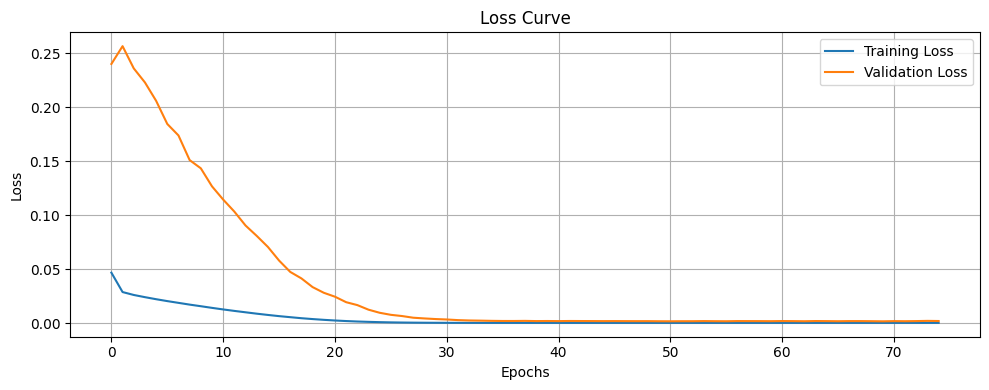

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

📊 Validation Metrics:
RMSE: 3912.11688
MAE : 2990.97956
R²  : 0.95025


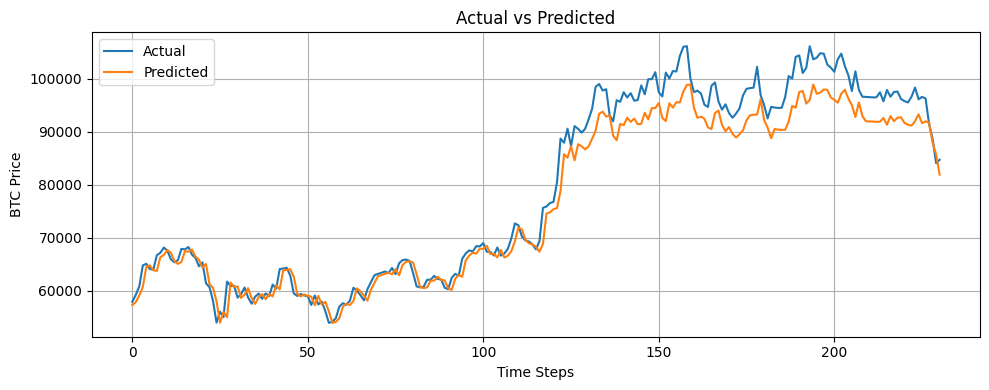

In [76]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/BTC_Prediction_Training/data/btc.csv')

# Preprocess
X_train, Y_train, X_test, Y_test, scaler = pre_processing(df)


# Save the scaler
import joblib
joblib.dump(scaler, '/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/btc_scaler.save')


# Train
model, history = model_training(X_train, Y_train)
print("✅ Model saved as 'btc_lstm_model.h5'")
print("✅ Scaler saved as 'btc_scaler.save'")

# Evaluate
plot_model_performance(model=trained_model.model,  # or just trained_model if not using wrapper
                       X_val=X_test,
                       Y_val=Y_test,
                       history=trained_model,
                       scaler=scaler)